In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from galsim import ImageF, InterpolatedImage, Image
import galsim
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.utils import util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens
from mejiro.exposure import Exposure
from mejiro.plots import plot_util
from mejiro.analysis import stats

Computing on pixel grid of size 47x47 (5.17"x5.17") with pixel scale 0.11 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 1)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F129 band


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


PSF F129 SCA01 (2048, 2048) 1 47 not found in cache /data/bwedig/mejiro/cached_psfs


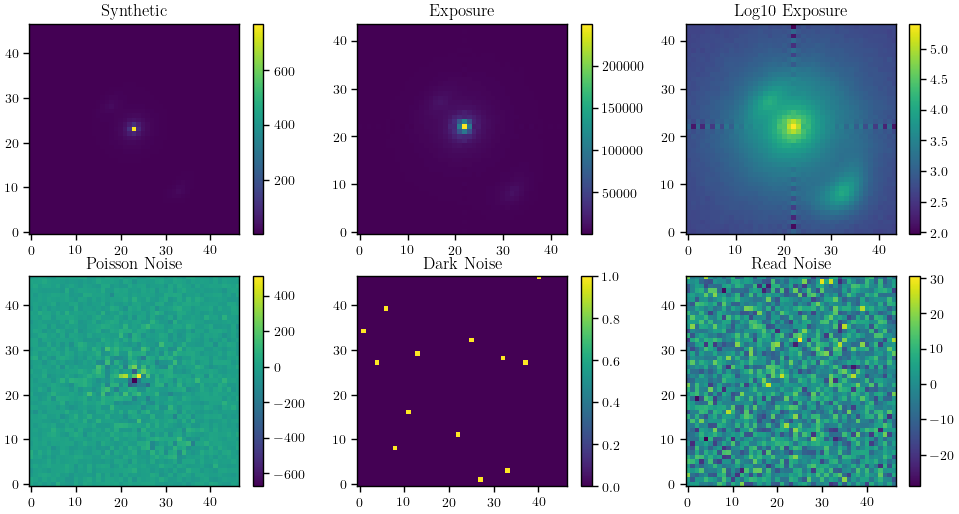

In [3]:
lens = SampleStrongLens()
roman = Roman()
band = 'F129'
scene_size = 5  # arcsec
oversample = 1
exposure_time = 1000
rng = galsim.UniformDeviate(42)

synth_no_subhalo = SyntheticImage(lens, roman, band, arcsec=scene_size, oversample=oversample, sca=1)
exposure_no_subhalo = Exposure(synth_no_subhalo, exposure_time=exposure_time, rng=rng, detector_effects=True, sky_background=True, return_noise=True, sca=1, sca_position=(2048, 2048), reciprocity_failure=False, ipc=False, nonlinearity=False, suppress_output=False)

_, ax = plt.subplots(2, 3, figsize=(12, 6))
ax00 = ax[0,0].imshow(synth_no_subhalo.image)
ax01 = ax[0,1].imshow(exposure_no_subhalo.exposure)
ax02 = ax[0,2].imshow(np.log10(exposure_no_subhalo.exposure))
ax10 = ax[1,0].imshow(exposure_no_subhalo.poisson_noise.array)
ax11 = ax[1,1].imshow(exposure_no_subhalo.dark_noise.array)
ax12 = ax[1,2].imshow(exposure_no_subhalo.read_noise.array)
plt.colorbar(ax00, ax=ax[0,0])
plt.colorbar(ax01, ax=ax[0,1])
plt.colorbar(ax02, ax=ax[0,2])
plt.colorbar(ax10, ax=ax[1,0])
plt.colorbar(ax11, ax=ax[1,1])
plt.colorbar(ax12, ax=ax[1,2])
ax[0,0].set_title('Synthetic')
ax[0,1].set_title('Exposure')
ax[0,2].set_title('Log10 Exposure')
ax[1,0].set_title('Poisson Noise')
ax[1,1].set_title('Dark Noise')
ax[1,2].set_title('Read Noise')
plt.show()

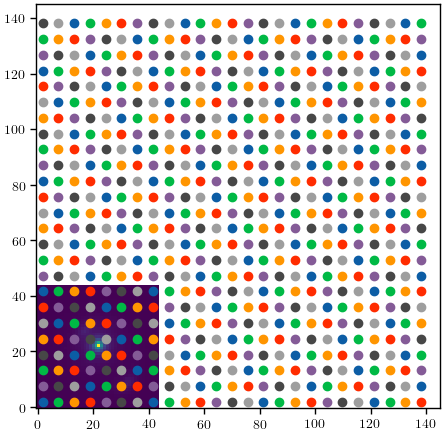

In [11]:
synth_no_subhalo.set_native_coords()

plt.imshow(exposure_no_subhalo.exposure)

for x, y in util.make_grid(5, 25):
    coord_x, coord_y = synth_no_subhalo.coords.map_coord2pix(x, y)
    plt.scatter(coord_x, coord_y)

plt.show()

In [4]:
masses = np.logspace(8, 10, 20)
concentration = 6
m200 = 1e8

# solve for image positions
image_x, image_y = lens.get_image_positions(pixel_coordinates=False)
halo_x, halo_y = image_x[0], image_y[0]
halo_x, halo_y = -1, -1

# compute subhalo parameters
Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=m200, c=concentration)

# build subhalo parameters
subhalo_type = 'TNFW'
kwargs_subhalo = {
    'alpha_Rs': alpha_Rs,
    'Rs': Rs_angle,
    'center_x': halo_x,
    'center_y': halo_y,
    'r_trunc': 5 * Rs_angle
}

Computing on pixel grid of size 141x141 (5.17"x5.17") with pixel scale 0.03666666666666667 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 3)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F129 band


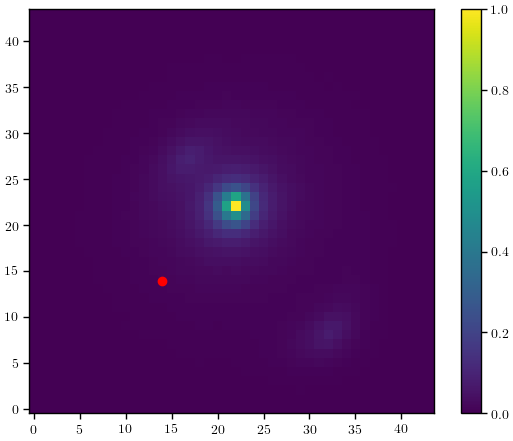

In [5]:
lens_with_subhalo = deepcopy(lens)
lens_with_subhalo.add_subhalo(subhalo_type, kwargs_subhalo)
synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, sca=1)
exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, poisson_noise=exposure_no_subhalo.poisson_noise, dark_noise=exposure_no_subhalo.dark_noise, read_noise=exposure_no_subhalo.read_noise, sca=1, sca_position=(2048, 2048), reciprocity_failure=False, ipc=False, nonlinearity=False)

synth.set_native_coords()
coords_x, coords_y = synth.coords_native.map_coord2pix(halo_x, halo_y)

plt.imshow(exposure.exposure)
plt.scatter(coords_x, coords_y, color='red')
plt.colorbar()
plt.show()

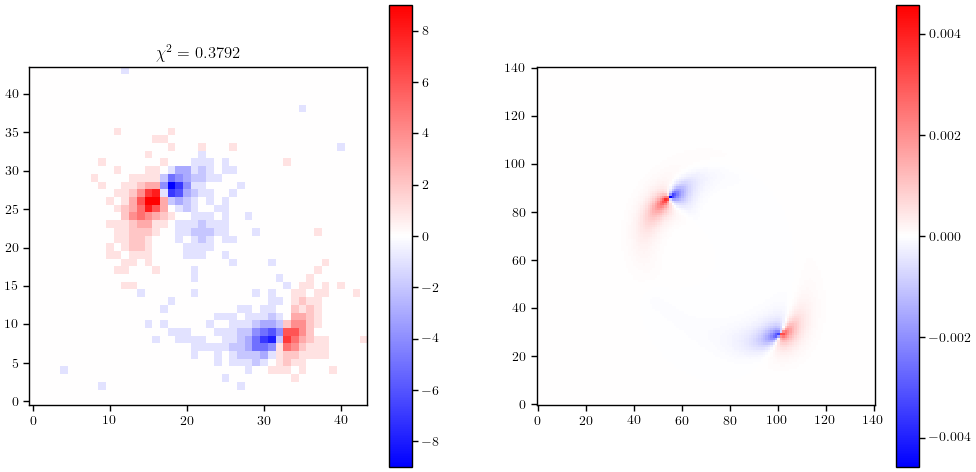

In [6]:
residual = exposure.exposure - exposure_no_subhalo.exposure
synth_residual = synth.image - synth_no_subhalo.image
                        
chi_square = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)

vmax = plot_util.get_limit(residual)
vmax_synth = plot_util.get_limit(synth_residual)

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0 = ax[0].imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)  # 
ax[0].set_title(r'$\chi^2=$ ' + f'{chi_square:.4f}')
ax1 = ax[1].imshow(synth_residual, cmap='bwr', vmin=-vmax_synth, vmax=vmax_synth)  # 
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()

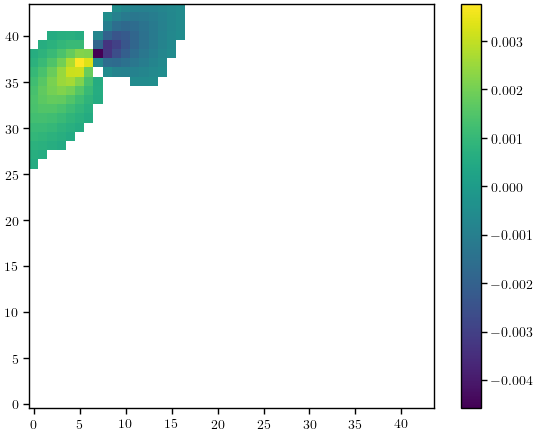

In [7]:
mask_quantile = 0.98
mask_threshold = np.quantile(np.abs(synth_residual), mask_quantile)
masked_synth_residual = np.ma.masked_where(np.abs(synth_residual) < mask_threshold, synth_residual)
masked_synth_residual = util.center_crop_image(masked_synth_residual, exposure.exposure.shape)
mask = np.ma.getmask(masked_synth_residual)
masked_exposure_no_subhalo = np.ma.masked_array(exposure_no_subhalo.exposure, mask=mask)

plt.imshow(masked_synth_residual)
plt.colorbar()
plt.show()

In [8]:
side = 50
chi2_array = np.empty((side, side))
chi2_array_list = []

for mass in tqdm(masses):
    # compute subhalo parameters
    Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=mass, c=concentration)

    for i, (halo_x, halo_y) in enumerate(util.make_grid(5, side)):
        # build subhalo parameters
        subhalo_type = 'TNFW'
        kwargs_subhalo = {
            'alpha_Rs': alpha_Rs,
            'Rs': Rs_angle,
            'center_x': halo_x,
            'center_y': halo_y,
            'r_trunc': 5 * Rs_angle
        }

        lens_with_subhalo = deepcopy(lens)
        lens_with_subhalo.add_subhalo(subhalo_type, kwargs_subhalo)
        synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, debugging=False, sca=1)
        exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, poisson_noise=exposure_no_subhalo.poisson_noise, dark_noise=exposure_no_subhalo.dark_noise, read_noise=exposure_no_subhalo.read_noise, suppress_output=True, sca=1, sca_position=(2048, 2048), reciprocity_failure=False, ipc=False, nonlinearity=False)

        # build mask based on synthetic image with subhalo
        synth_residual = synth.image - synth_no_subhalo.image
        mask_threshold = np.quantile(np.abs(synth_residual), mask_quantile)
        masked_synth_residual = np.ma.masked_where(np.abs(synth_residual) < mask_threshold, synth_residual)
        masked_synth_residual = util.center_crop_image(masked_synth_residual, exposure.exposure.shape)
        mask = np.ma.getmask(masked_synth_residual)

        # mask images
        masked_exposure_no_subhalo = np.ma.masked_array(exposure_no_subhalo.exposure, mask=mask)
        masked_exposure_with_subhalo = np.ma.masked_array(exposure.exposure, mask=mask)

        # calculate chi square
        chi_square = stats.chi_square(np.ma.compressed(masked_exposure_with_subhalo), np.ma.compressed(masked_exposure_no_subhalo))

        chi_square = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)
        chi2_array[i // side, i % side] = chi_square
    
    chi2_array_list.append(chi2_array)
    chi2_array = np.empty((side, side))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:44<?, ?it/s]


KeyboardInterrupt: 

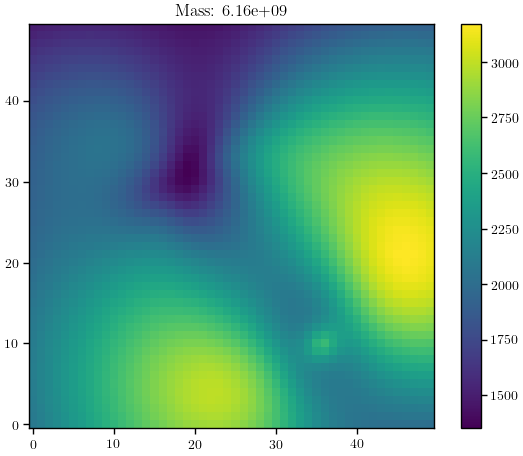

In [61]:
idx = -3
plt.imshow(chi2_array_list[idx])
plt.colorbar()
plt.title(f'Mass: {masses[idx]:.2e}')
plt.show()

In [62]:
from scipy.stats import chi2

# initialize chi2 rv
pixels_unmasked = masked_synth_residual.count()
dof = pixels_unmasked - 3
rv = chi2(dof)
threshold_chi2 = rv.isf(0.001)
print(f'Threshold chi2: {threshold_chi2:.2f}')

ldsm = np.empty((side, side))

for i in range(side):
    for j in range(side):
        for mass, chi2_array in zip(masses, chi2_array_list):
            chi2 = chi2_array[i, j]
            pval = rv.sf(chi2)
            # print(f'{mass=:.2e} {chi2=:.2f} {pval=:.4f}')
            if pval < 0.001:
                ldsm[i, j] = mass
                # print(f'pval threshold reached: {mass=:.2e}')
                break

Threshold chi2: 76.08


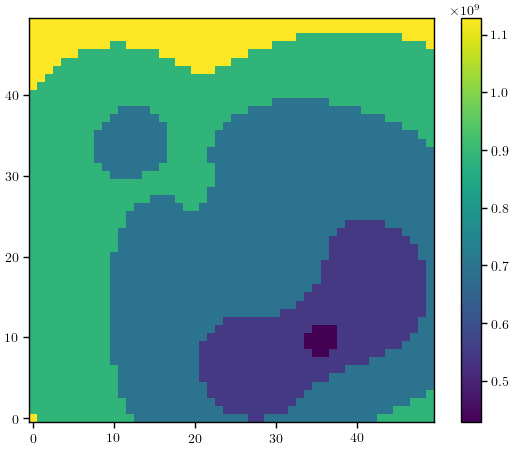

In [63]:
plt.imshow(ldsm)
plt.colorbar()
plt.show()

In [64]:
np.save(os.path.join(data_dir, 'output', 'lowest_detectable_subhalo_mass_hwo', 'ldsm_roman_SAMPLE.npy'), ldsm)
np.save(os.path.join(data_dir, 'output', 'lowest_detectable_subhalo_mass_hwo', 'roman_exposure_SAMPLE.npy'), exposure_no_subhalo.exposure)

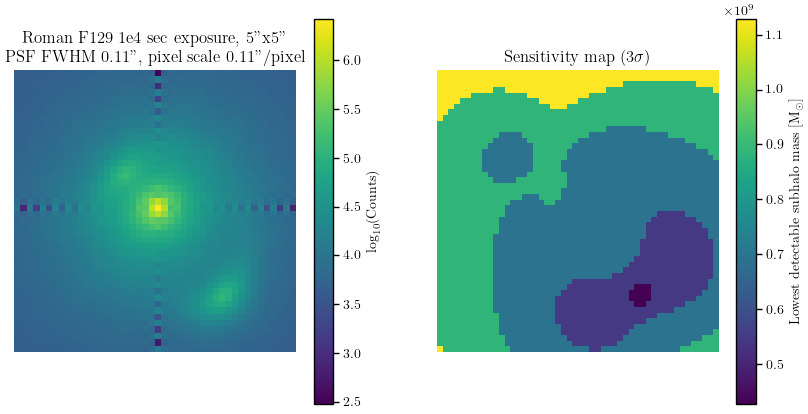

In [65]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax0 = ax[0].imshow(np.log10(exposure_no_subhalo.exposure))
ax1 = ax[1].imshow(ldsm)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title(f'Roman F129 1e4 sec exposure, 5"x5"\nPSF FWHM {roman.get_psf_fwhm(band):.2f}", pixel scale 0.11"/pixel')
ax[1].set_title('Sensitivity map ($3\sigma$)')
plt.colorbar(ax0, ax=ax[0], label=r'$\log_{10}$(Counts)')
plt.colorbar(ax1, ax=ax[1], label='Lowest detectable subhalo mass [M$_\odot$]')
plt.show()